In [4]:
%pip install numpy
%pip install matplotlib
%pip install pymunk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Rendering 240 frames at 30.0 fps


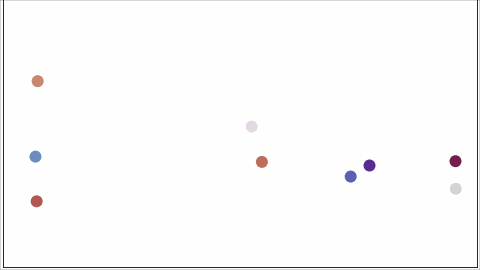

In [5]:

from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

import pymunk
from pymunk.vec2d import Vec2d



def setup_space(width, height, e):
    space = pymunk.Space()
    space.gravity = 0, -9.820
    space.damping = 0.9999
    static_body = space.static_body
    gap = 0.1
    static_lines = [
        # Bottom floor
        pymunk.Segment(static_body, (gap, gap), (width - gap, gap), 0.01),
        # Right wall
        pymunk.Segment(
            static_body, (width - gap, gap), (width - gap, height * 100), 0.01
        ),
        # Left wall
        pymunk.Segment(static_body, (gap, gap), (gap, height * 100), 0.01),
    ]
    for line in static_lines:
        line.elasticity = e
        line.friction = 0
    space.add(*static_lines)
    return space

def mk_ball(x, y, vx, vy, radius, e, space):
    body = pymunk.Body(0, 0)
    body.position = Vec2d(x, y)
    body.velocity = Vec2d(vx, vy)
    #body.start_position = Vec2d(*body.position)
    shape = pymunk.Circle(body, radius)
    shape.density = 1
    shape.elasticity = e
    space.add(body, shape)
    body.radius = radius
    return body



def sim(space, balls, T, dt, height):
    ts = np.arange(0, T, dt)
    positions = []
    for t in ts:
        # log ball positions
        positions.append([np.array(b.position) for b in balls])
        # Step the simulation
        space.step(dt)
        for b in balls:
            if (b in space.bodies):
                r = list(b.shapes)[0].radius
                if b.position[1] > height + r: # ball is out of view
                    space.remove(b, list(b.shapes)[0])
        if len(space.bodies) == 0: # no balls left in the simulation
            break
    return ts[: len(positions)], positions


def initialize():
    width, height = 16, 9
    e = 0.90 # Elasticity of objects.  Must be <=1.
    # Values closer to 1 mean the bounces do not lose much energy.
    space = setup_space(width, height, e)
    
    # Create a circle with radius R, composed of N balls with radius r
    N, R, r = 24, 2.5, 0.2
    # center of the circle
    cx, cy = width / 2, height / 2
    # velocity of each ball in the tangential direction
    vt = 3.0
    # random component of each ball's velocity (uniform)
    vrand = 0.5
    
    balls = []
    np.random.seed(0) # make sure that outputs of this function are repeatable
    for t in np.linspace(0, 2 * np.pi, N, endpoint=False):
        balls.append(mk_ball(
            x = cx + R*np.cos(t),
            y = cy + R*np.sin(t),
            vx = vt*np.cos(t+np.pi/2) + np.random.uniform(-vrand,+vrand),
            vy = vt*np.sin(t+np.pi/2) + np.random.uniform(-vrand,+vrand),
            radius = r, 
            e = e, 
            space = space))
                     
    return width, height, space, balls


T = 4 # how long to simulate?
dt = 1/300 # we simulate 300 timesteps per second

# Forward simulation
width, height, space, balls = initialize()
f_ts, f_positions = sim(
    space, balls, T, dt, height
)

# Backward simulation
width, height, space, balls = initialize()
# To simulate backwards, we invert the initial velocity of each ball
# and set the elasticity of each object to the reciprocal of the true value
for b in balls:
    s = list(b.shapes)[0]
    s.elasticity = 1 / s.elasticity
    b.velocity = -1 * b.velocity
for s in space.static_body.shapes:
    s.elasticity = 1 / s.elasticity    
b_ts, b_positions = sim(
    space, balls, T, dt, height
)

# Stitch the resulting trajectories together
ts = list(-1 * b_ts[-1:0:-1]) + list(f_ts)
positions = b_positions[-1:0:-1] + f_positions    



subsampling = 10 # render one out of this number of timesteps.
# Since we have 300 timesteps per second, 10 yields 30 fps. 5 yields 60 fps.

dpi = 30 # use low values for preview. dpi=120 yields fullhd video if width,height are 16,9

# Prepare the figure and axes
fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
ax.set(xlim=[0, width], ylim=[0, height])
ax.set_aspect("equal")
ax.set_position([0, 0, 1, 1])
fig.set(facecolor="y")

# Prepare the patches for the balls
cmap = plt.get_cmap("twilight")
circles = [plt.Circle((0, 0), radius=b.radius, facecolor=cmap(i/len(balls)))
           for i,b in enumerate(balls)]
[ax.add_patch(c) for c in circles]

# Draw the walls as black lines
for s in space.static_body.shapes:
    ax.plot([s.a.x, s.b.x], [s.a.y, s.b.y], linewidth=2, color="k")

# animation function. This is called for each frame, passing an entry in positions
def drawframe(p):
    for i, c in enumerate(circles):
        c.set_center(p[i])
    return circles

anim = animation.FuncAnimation(
    fig,
    drawframe,
    frames=positions[::subsampling],
    interval=dt * subsampling * 1000,
    blit=True,
)

plt.close(fig)
print(f"Rendering {len(positions[::subsampling])} frames at {1/(dt * subsampling)} fps")

f = r"animation.gif" 
writergif = animation.PillowWriter(fps=30) 
anim.save(f, writer=writergif)

"""
from IPython.display import Video
Video.from_file("animation.mp4")"""

from IPython.display import Image
Image(open('animation.gif','rb').read())


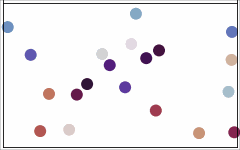

In [24]:

from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

import pymunk
import pymunk.pygame_util
from pymunk.vec2d import Vec2d


gap = 0.1


def setup_space(width, height, e):
    space = pymunk.Space()
    space.gravity = 0, 0
    space.damping = 1
    static_body = space.static_body
    #gap = 0.1
    static_lines = [# Top floor
        pymunk.Segment(static_body, (gap, height-gap), (width - gap, height-gap ), 0.01),
        # Bottom floor
        pymunk.Segment(static_body, (gap, gap), (width - gap, gap), 0.01),
        # Right wall
        pymunk.Segment(
            static_body, (width - gap, gap), (width - gap, height * 100), 0.01
        ),
        # Left wall
        pymunk.Segment(static_body, (gap, gap), (gap, height * 100), 0.01),
    ]
    for line in static_lines:
        line.elasticity = e
        line.friction = 0
    space.add(*static_lines)
    return space

def mk_ball(x, y, vx, vy, radius, e, space,idty=1):
    body = pymunk.Body(0, 0)
    body.position = Vec2d(x, y)
    body.velocity = Vec2d(vx, vy)
    #body.start_position = Vec2d(*body.position)
    shape = pymunk.Circle(body, radius)
    shape.density = 1
    shape.elasticity = e
    space.add(body, shape)
    body.radius = radius
    if idty == 1 : 
        shape.color = (255, 0, 0, 255)
    elif idty == 2 :
        shape.color = (255, 255, 255, 255)
    else :
        shape.color = (255, 0, 0, 255)
    #shape.draw_circle(pos: Vec2d, angle: float, radius: float, outline_color: SpaceDebugColor, fill_color: SpaceDebugColor)
    return body



def sim(space, balls, T, dt, height):
    ts = np.arange(0, T, dt)
    positions = []
    for t in ts:
        # log ball positions
        positions.append([np.array(b.position) for b in balls])
        # Step the simulation
        space.step(dt)
        for b in balls:
            if (b in space.bodies):
                r = list(b.shapes)[0].radius
                if b.position[1] > height + r: # ball is out of view
                    space.remove(b, list(b.shapes)[0])
        if len(space.bodies) == 0: # no balls left in the simulation
            break
    return ts[: len(positions)], positions


def initialize():
    width, height = 8, 5
    e = 1 # Elasticity of objects.  Must be <=1.
    space = setup_space(width, height, e)
    
    #  N balls with radius r
    N,  r = 20, 0.2

    # random component of each ball's velocity (uniform)
    vrand = 10
    
    balls = []
    np.random.seed(0) # make sure that outputs of this function are repeatable
    for t in np.linspace(0, 2 * np.pi, N, endpoint=False):
        balls.append(mk_ball(
            x = np.random.uniform(gap,width-gap),
            y = np.random.uniform(gap,height-gap),
            vx = np.random.uniform(-vrand,+vrand),
            vy = np.random.uniform(-vrand,+vrand),
            radius = r, 
            e = e, 
            space = space))
                     
    return width, height, space, balls


T = 4 # how long to simulate?
dt = 1/300 # we simulate 300 timesteps per second

# Forward simulation
width, height, space, balls = initialize()
f_ts, f_positions = sim(
    space, balls, T, dt, height
)


ts = list(f_ts)

positions = f_positions    



subsampling = 10 # render one out of this number of timesteps.
# Since we have 300 timesteps per second, 10 yields 30 fps. 5 yields 60 fps.

dpi = 30 # use low values for preview. dpi=120 yields fullhd video if width,height are 16,9

# Prepare the figure and axes
fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
ax.set(xlim=[0, width], ylim=[0, height])
ax.set_aspect("equal")
ax.set_position([0, 0, 1, 1])
fig.set(facecolor="y")

# Prepare the patches for the balls
cmap = plt.get_cmap("twilight")
circles = [plt.Circle((0, 0), radius=b.radius, facecolor=cmap(i/len(balls)))
           for i,b in enumerate(balls)]
[ax.add_patch(c) for c in circles]

# Draw the walls as black lines
for s in space.static_body.shapes:
    ax.plot([s.a.x, s.b.x], [s.a.y, s.b.y], linewidth=2, color="k")

    
# animation function. This is called for each frame, passing an entry in positions
def drawframe(p):
    for i, c in enumerate(circles):
        c.set_center(p[i])
        
    
        
    return circles

anim = animation.FuncAnimation(
    fig,
    drawframe,
    frames=positions[::subsampling],
    interval=dt * subsampling * 1000,
    blit=True,
)

plt.close(fig)
#print(f"Rendering {len(positions[::subsampling])} frames at {1/(dt * subsampling)} fps")

f = r"animation.gif" 
writergif = animation.PillowWriter(fps=30) 
anim.save(f, writer=writergif)


from IPython.display import Image
Image(open('animation.gif','rb').read())

done computing
done generating image


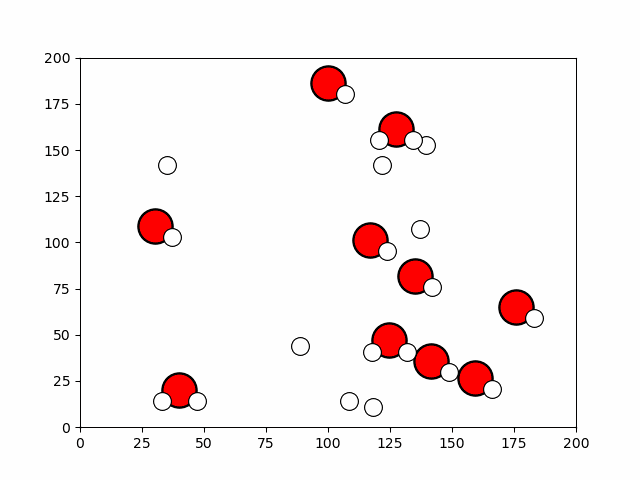

In [89]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 21 18:16:59 2024

@author: brian
"""



import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

from IPython import get_ipython #pour l'affichage des graphes dans une fenêtre hors IDE

get_ipython().run_line_magic('matplotlib', 'inline') #affichage des graphes dans une fenêtres hors IDE



#from IPython.display import HTML

"""
import pymunk
import pymunk.pygame_util
from pymunk.vec2d import Vec2d"""



# Initialize Pygame


# Set up display
width, height = 200, 200  #en 160x160 ça va suffisamment vite
#screen = pygame.display.set_mode((width, height))
#pygame.display.set_caption("Réaction entre l'acide chlorhydrique et l'hydroxyde de sodium")
#print("alive")
# Define molecule class
class Molecule:
    def __init__(self,identity=1):
        if identity == 1 :
            self.id = 1
            self.radius = 10
            self.color = (255, 0, 0)
            
            self.x = random.randint(self.radius, width/2 - self.radius)

            self.mass = 17
        elif identity == 2 :
            self.id = 0
            self.radius = 5
            self.color = (255, 255, 255)
            self.x = random.randint(self.radius+width/2, width - self.radius)

            self.mass = 1
        elif identity == 3 :
            self.id = 3
            self.radius = 10
            self.color = (255, 0, 0)
            self.x = random.randint(self.radius, width - self.radius)
            self.mass = 18
        else :
            self.id = 4
            self.radius = 0
            self.color = (255, 255, 255)
            self.x = random.randint(self.radius, width - self.radius)
        
        self.x = random.randint(self.radius, width - self.radius)
        self.y = random.randint(self.radius, height - self.radius)
        self.vx = random.uniform(-1, 1)/4
        self.vy = random.uniform(-1, 1)/4
    
    def __del__(self):
        pass
    
    def addPosition(self, posx,posy):
        self.x += posx
        self.y += posy
        
    def addVelocity(self, velx,vely):
        self.vx += velx
        self.vy += vely

    def move(self):
        self.x += self.vx
        self.y += self.vy

        # Bounce off walls
        if self.x <= self.radius or self.x >= width - self.radius:
            self.vx *= -1
            if self.x <= self.radius:
                self.x +=1
            else :
                self.x -=1
        if self.y <= self.radius or self.y >= height - self.radius:
            self.vy *= -1
            if self.y <= self.radius:
                self.y +=1
            else :
                self.y -=1
            
    def collide(self,p1,p2):
        dXx = p1.x-p2.x
        dXy = p1.y-p2.y
        dist = np.sqrt(dXx**2 + dXy**2)
        if dist < p1.radius+p2.radius:
            
            if (p1.id ==0 and p2.id == 1) or (p2.id ==0 and p1.id == 1):
                if p1.id == 1 :
                    p1.id = 3
                    p1.radius = 10
                    p1.color = (255, 0, 0)
                    p1.mass = 18
                    p2.id = 4
                    p2.radius = 0
                    p2.color = (255, 255, 255)
                    
                else :
                    p2.id = 3
                    p2.radius = 10
                    p2.color = (255, 0, 0)
                    p2.mass = 18
                    p1.id = 4
                    p1.radius = 0
                    p1.color = (255, 255, 255)
                
            else :
                offset = dist-(p1.radius+p2.radius)
                p1.addPosition((-dXx/dist)*offset/2,(-dXy/dist)*offset/2)
                p2.addPosition((dXx/dist)*offset/2,(dXy/dist)*offset/2)
                total_mass = p1.mass+p2.mass
                #dv1 = -2*p2.mass/total_mass*np.inner(p1.V-p2.V,p1.X-p2.X)/np.sum((p1.X-p2.X)**2)*(p1.X-p2.X)
                scalprod1 = (p1.vx-p2.vx)*(p1.x-p2.x)+ (p1.vy-p2.vy)*(p1.y-p2.y)
                scalprod2 = (p2.vx-p1.vx)*(p2.x-p1.x)+ (p2.vy-p1.vy)*(p2.y-p1.y)
                
                dv1x = -2*p2.mass/total_mass*scalprod1/((p1.x-p2.x)**2+(p1.y-p2.y)**2)*(p1.x-p2.x)
                dv1y = -2*p2.mass/total_mass*scalprod1/((p1.x-p2.x)**2+(p1.y-p2.y)**2)*(p1.y-p2.y)
                
                dv2x = -2*p1.mass/total_mass*scalprod2/((p2.x-p1.x)**2+(p2.y-p1.y)**2)*(p2.x-p1.x)
                dv2y = -2*p1.mass/total_mass*scalprod2/((p2.x-p1.x)**2+(p2.y-p1.y)**2)*(p2.y-p1.y)
                
                
                p1.addVelocity(dv1x,dv1y)
                p2.addVelocity(dv2x,dv2y)
        
    
        

# Create molecules

molecules = [Molecule(1) for _ in range(10)] + [Molecule(2) for _ in range(10)]

# Main loop
running = True
i = 0
imax = 2000

subsamp = 40

storesize=int(imax//subsamp)
storagex=[[np.zeros(storesize)] for _ in molecules]
storagey=[[np.zeros(storesize)] for _ in molecules]
storestate=[[np.zeros(storesize)] for _ in molecules]

while running:
    i += 1
    
    if i>=imax:
        running = False

    # Update molecule positions
    for molecule in molecules:
        molecule.move()
        for molecule2 in molecules :
            if molecule2!=molecule :
                molecule.collide(molecule,molecule2)

    # save molecules
    #screen.fill((255, 255, 255))
    if (i-1)%subsamp == 0 :
        for molecule in range(len(molecules)):
            storagex[molecule][0][i//subsamp]=molecules[molecule].x
            storagey[molecule][0][i//subsamp]=molecules[molecule].y
            storestate[molecule][0][i//subsamp]=molecules[molecule].id
            

"""
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False, 
    left = False,# ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
"""


fig, ax = plt.subplots()



scat = ax.scatter([storagex[i][0] for i in range(len(storagex))], [storagey[i][0] for i in range(len(storagex))], c="b", s=5,alpha=0)
line2 = ax.plot([storagex[i][0] for i in range(len(storagex))], [storagey[i][0] for i in range(len(storagex))],alpha=0)[0]

temphandle1 = ax.scatter([storagex[i][0] for i in range(len(storagex))], [storagey[i][0] for i in range(len(storagex))], c="b", s=5,alpha=0)


temphandle2 = ax.scatter([storagex[i][0] for i in range(len(storagex))], [storagey[i][0] for i in range(len(storagex))], c="b", s=5,alpha=0)


temphandle3 = ax.scatter([storagex[i][0] for i in range(len(storagex))], [storagey[i][0] for i in range(len(storagex))], c="b", s=5,alpha=0)


def update(p):
    
    X = [storagex[_][0][p] for _ in range(len(storagex))]
    Y =  [storagey[_][0][p] for _ in range(len(storagex))]
    idy = [storestate[_][0][p] for _ in range(len(storagex))]
    
    ax.clear()
    
    X1 = np.array([X[_] for _ in range(len(X)) if idy[_]==1])
    Y1 = np.array([Y[_] for _ in range(len(X)) if idy[_]==1])
    

    ax.set(xlim=[0, width], ylim=[0, height])
    
    ax.scatter(X1,Y1, color=(0,0,0), s=160*4,alpha=1)  
    ax.scatter(X1,Y1, color=(1,0,0), s=120*4,alpha=1)
    
    ax.scatter(X1+7,Y1-6, color=(0,0,0), s=160*1,alpha=1)  
    ax.scatter(X1+7,Y1-6, color=(1,1,1), s=120*1,alpha=1) 
    
    X2 = np.array([X[_] for _ in range(len(X)) if idy[_]==0])
    Y2 = np.array([Y[_] for _ in range(len(X)) if idy[_]==0])
    

    ax.scatter(X2,Y2, color=(0,0,0), s=160,alpha=1)  
    ax.scatter(X2,Y2, color=(1,1,1), s=120*1,alpha=1)
    
    
    X3 = np.array([X[_] for _ in range(len(X)) if idy[_]==3])
    Y3 = np.array([Y[_] for _ in range(len(X)) if idy[_]==3])
    
    ax.scatter(X3,Y3, color=(0,0,0), s=160*4,alpha=1)  
    ax.scatter(X3,Y3, color=(1,0,0), s=120*4,alpha=1)
    
    ax.scatter(X3+7,Y3-6, color=(0,0,0), s=160*1,alpha=1)  
    ax.scatter(X3+7,Y3-6, color=(1,1,1), s=120*1,alpha=1) 
    
    ax.scatter(X3-7,Y3-6, color=(0,0,0), s=160*1,alpha=1)
    ax.scatter(X3-7,Y3-6, color=(1,1,1), s=120*1,alpha=1)
    
    
    
    return (scat,line2)



print("done computing")

positions = [i for i in range(len(storagex[0][0]))]


anim = animation.FuncAnimation(
    fig,
    update,
    frames=positions,
    interval=30,
    blit=True,
)

plt.close(fig)

f = r"animation.gif" 
writergif = animation.PillowWriter(fps=30) 
anim.save(f, writer=writergif)


print("done generating image")


from IPython.display import Image
Image(open('animation.gif','rb').read())

In [77]:
storestate

[[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])],
 [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 3., 3., 3., 3., 3., 3.,
         3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
         3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])],
 [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])],
 [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])],
 [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
   